## 2 Layer MLP for Dark Knoweldge Experiments w/AlignMNIST

75 epochs of RMSProp on AlignMNIST

800 x 800 network with normalized the weights after each epoch

no dropout .. another baseline


see  http://www.r2rt.com/posts/implementations/2016-03-29-implementing-batch-normalization-tensorflow/

https://github.com/tensorflow/tensorflow/blob/b3621c95160a916d4d255f9f44318b9d465701af/tensorflow/contrib/layers/python/layers/layers.py


https://www.reddit.com/r/MachineLearning/comments/2bopxs/question_about_the_maxnorm_constraint_used_with/



https://arxiv.org/pdf/1207.0580.pdf

https://arxiv.org/pdf/1503.02531v1.pdf

http://www.kdnuggets.com/2015/04/preventing-overfitting-neural-networks.html

https://www.reddit.com/r/MachineLearning/comments/2bopxs/question_about_the_maxnorm_constraint_used_with/

and https://github.com/tensorflow/tensorflow/issues/608

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
%run augmentmnist.py

In [3]:
num_epochs = 75
batch_size = 125

learning_rate = 0.001


In [4]:
# Network Parameters
n_hidden_1 = 800 # 1st layer num features
n_hidden_2 = 800 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

std_0  = np.sqrt(6.0/(n_input+n_hidden_1))
std_h1 = np.sqrt(6.0/(n_hidden_1+n_hidden_2))
std_h2 = np.sqrt(6.0/(n_hidden_2+n_classes))

logfile = "2BwD-layer-dlk-alignmnist-4"

In [5]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

xt = tf.placeholder("float", [None, n_input])
yt = tf.placeholder("float", [None, n_classes])

### need to try again with Dropout on both layers

In [6]:
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1']))
    layer_2 =tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return tf.matmul(layer_2, weights['out']) + biases['out']

In [7]:
def multilayer_perceptron_test(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return tf.matmul(layer_2, weights['out']) + biases['out']

In [8]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=std_h2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.001))
}

In [9]:
mlp = multilayer_perceptron(x, weights, biases )
mlp_test = multilayer_perceptron_test(xt, weights, biases  )

In [10]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mlp, y)) 
gs = tf.get_variable("global_step",[],trainable=False,initializer=tf.constant_initializer(0))
lr = tf.constant(learning_rate) 

### don't include dropout in accuracy calculations

In [11]:
!rm -rf ./logs/{logfile}
!ls logs

2-layer-dk-alignmnist           2-layer-modern-mlp-alignmnist
2-layer-dlk-alignmnist          2BwD-layer-dlk-alignmnist
2-layer-mlp-alignmnist-wdropout 5-layer-mlp-alignmnist-wdropout
2-layer-mlp-mnist-temp          5-layer-mlp-infimnist
2-layer-mlp-mnist-watch


### Original MNIST Data

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)
trX_0, trY_0 = mnist.train.images, mnist.train.labels
teX_0, teY_0 = mnist.test.images, mnist.test.labels

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [13]:
alignmnist = AlignMNIST()

 see https://github.com/tensorflow/tensorflow/issues/424

In [14]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops

from tensorflow.python.ops import variable_scope as vs


In [15]:
# do i have this right  ?

def max_norm_constraint(_weights, _biases):
    
    norms0 = np.array([50.0, 60.0, 6.0, 3.0, 1.0, 1.0])
    norms0 = norms0*1.0

    n0 = tf.constant(norms0[0], dtype=tf.float32)
    n1 = tf.constant(norms0[1],  dtype=tf.float32)
    n2 = tf.constant(norms0[2],  dtype=tf.float32)
    n3 = tf.constant(norms0[3],  dtype=tf.float32)
    n4 = tf.constant(norms0[4],  dtype=tf.float32)
    n5 = tf.constant(norms0[5],  dtype=tf.float32)
    
    norm_h1 =   tf.sqrt(tf.reduce_sum(tf.square(_weights['h1'])))
    norm_h2 =   tf.sqrt(tf.reduce_sum(tf.square(_weights['h2'])))
    norm_hout = tf.sqrt(tf.reduce_sum(tf.square(_weights['out'])))
                        
    norm_b1 =   tf.sqrt(tf.reduce_sum(tf.square(_biases['b1'])))
    norm_b2 =   tf.sqrt(tf.reduce_sum(tf.square(_biases['b2'])))
    norm_bout = tf.sqrt(tf.reduce_sum(tf.square(_biases['out'])))

    
    pred = tf.greater(norm_h1 , n0)
    _weights['h1'] = control_flow_ops.cond(pred, lambda: tf.div(_weights['h1'], norm_h1), lambda: _weights['h1'])
    
    pred = tf.greater(norm_h2 , n1)
    _weights['h2'] = control_flow_ops.cond(pred, lambda: tf.div(_weights['h2'], norm_h2), lambda: _weights['h2'])
    
    pred = tf.greater(norm_hout , n2)
    _weights['out'] = control_flow_ops.cond(pred, lambda: tf.div(_weights['out'], norm_hout), lambda: _weights['out'])
            
    pred = tf.greater(norm_b1 , n3)
    _biases['b1'] = control_flow_ops.cond(pred, lambda: tf.div(_biases['b1'], norm_b1), lambda: _biases['b1'])
    
    pred = tf.greater(norm_b2 , n4)
    _biases['b2'] = control_flow_ops.cond(pred, lambda: tf.div(_biases['b2'], norm_b2), lambda: _biases['b2'])

    pred = tf.greater(norm_bout , n5)
    _biases['out'] = control_flow_ops.cond(pred, lambda: tf.div(_biases['out'], norm_bout), lambda: _biases['out'])
       
    return tf.constant(norms0[0], dtype=tf.float32)

In [28]:
test_accuracies = []
train_accuracies = []
norms = []

for i in range(100):
    alignmnist = AlignMNIST()
    train_op = tf.contrib.layers.optimize_loss(cost, global_step=gs, learning_rate=lr,optimizer="RMSProp")
    max_norm_op = max_norm_constraint(weights, biases)

    pred = tf.equal(tf.argmax(mlp, 1), tf.argmax(y, 1)) # Count correct predictions
    train_acc_op = tf.reduce_mean(tf.cast(pred, "float"))  # Cast boolean to float to average
    #tf.scalar_summary("training accuracy", train_acc_op)

    test_pred = tf.equal(tf.argmax(mlp_test, 1), tf.argmax(yt, 1)) # Count correct predictions
    test_acc_op = tf.reduce_mean(tf.cast(test_pred, "float"))  # Cast boolean to float to average
    #tf.scalar_summary("test 0 accuracy", test_acc_op)

    #writer = tf.train.SummaryWriter("./logs/{0}".format(logfile), sess.graph) # for 0.8
    #merged = tf.merge_all_summaries()
          
    with tf.Session() as sess:
        
        tf.initialize_all_variables().run()

    # create a log writer. run 'tensorboard --logdir=./logs/{logfile}'
   
        sess.run(max_norm_op)

        for epoch in range(2):
            trX, trY = alignmnist.next_epoch()

            for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX), batch_size)):
                sess.run(train_op, feed_dict={x: trX[start:end], y: trY[start:end]})

            sess.run(max_norm_op)


            trn_acc, tst_acc = sess.run([train_acc_op, test_acc_op], feed_dict={x: trX, y: trY, xt: teX_0, yt: teY_0})
            #writer.add_summary(summary, epoch)  


            print(epoch, trn_acc, tst_acc)
            train_accuracies.append(trn_acc)
            test_accuracies.append(tst_acc)

            nrms= [np.linalg.norm(weights['h1'].eval()),np.linalg.norm(weights['h2'].eval()), np.linalg.norm(weights['out'].eval()), np.linalg.norm(biases['b1'].eval()),np.linalg.norm(biases['b2'].eval()),np.linalg.norm(biases['out'].eval())]
            print nrms
            norms.append(nrms)
            writer.flush()
        

(0, 0.96998334, 0.95929998)
[1.000017, 50.92754, 0.9999997, 2.8767266, 0.38060847, 0.019276755]
(1, 0.95885003, 0.97460002)
[1.0000167, 53.540356, 1.0000001, 2.8934255, 0.61607522, 0.066759184]
(0, 0.97486669, 0.96749997)
[49.990677, 50.907757, 1.0, 2.756165, 0.37869224, 0.022361267]
(1, 0.96385002, 0.9777)
[1.0000156, 53.527569, 1.0000001, 2.7622385, 0.62265515, 0.057664622]
(0, 0.97235, 0.96579999)
[50.000713, 50.935467, 0.99999982, 2.7350247, 0.36257568, 0.017452713]
(1, 0.9684, 0.97729999)
[1.0000184, 53.530972, 0.99999982, 2.7530963, 0.55639946, 0.051071223]
(0, 0.96885002, 0.95920002)
[49.995628, 50.953915, 0.99999994, 2.9125488, 0.37396094, 0.024777452]
(1, 0.96641666, 0.97780001)
[1.0000163, 53.568703, 1.0, 2.9249277, 0.61312139, 0.058107249]
(0, 0.97451669, 0.96670002)
[1.0000157, 50.924599, 0.99999976, 2.8730028, 0.3683621, 0.027475618]
(1, 0.96945, 0.98269999)
[1.0000178, 53.530125, 1.0000001, 2.8856587, 0.60122418, 0.064867288]
(0, 0.97065002, 0.96420002)
[1.0000157, 50.822

In [23]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

/Users/charlesmartin14/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


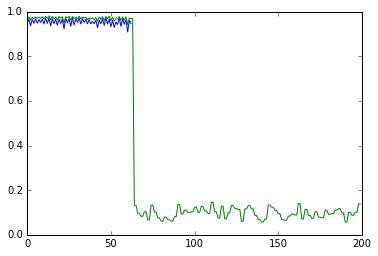

In [24]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [25]:
np.max(test_accuracies)

0.98040003

Number test errors is

In [26]:
10000*(1.0-np.max(test_accuracies))

195.99974155426025

In [27]:
print norms[0]
print norms[-1]

[1.000018, 51.163795, 0.9999997, 2.7130308, 0.38692814, 0.026154401]
[48.747219, 48.928699, 0.99999994, 2.7886932, 0.27928257, 0.0024301391]


#### What is the best way to implement the cutoff ?

by the norm of the weights at each layer ?

see also:  http://keras.io/constraints/

Does this just reflect the loss decreasing ?

Can we simply bound the norm?

In [ ]:
for i in range(6):
    plt.plot([nrm[i] for nrm in norms])

In [ ]:
# 164
